# Coursework: Self-supervised learning

**Submission:** You are asked to submit two versions of your notebook:
1. You should submit the raw notebook in `.ipynb` format with *all outputs cleared*. Please name your file `coursework.ipynb`.
2. Additionally, you will be asked to submit an exported version of your notebook in `.pdf` format, with *all outputs included*. We will primarily use this version for marking, but we will use the raw notebook to check for correct implementations. Please name this file `coursework_export.pdf`.

## Your details

Authors: **Anton Zhitomirsky**

DoC alias: **az620**

## Setup

In [3]:
! pip install lightning medmnist tensorboard tensorboardX

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import models
# from torchvision import transforms
from torchvision.transforms import v2
from pytorch_lightning import LightningModule, LightningDataModule, Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from torchmetrics.functional import auroc
from PIL import Image
from medmnist.info import INFO
from medmnist.dataset import MedMNIST

# Set a random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## **Part A:** Implement a dataset suitable for contrastive learning.

Dataset: [MedMNIST Pneumonia](https://medmnist.com/) (chest X-ray images downsampled to 28 $\times$ 28 pixels), with binary labels indicating the presence of Pneumonia.

### **Task A-1:** Complete the dataset implementation.

- implement a dataset class `SimCLRPneumoniaMNISTDataset`
- suitable for training a self-supervised model with a contrastive objective
- For each sample, your dataset class should return two 'views' of the corresponding image, forming the positive pairs for contrastive learning.
- It is up to you to design suitable augmentation pipeline for generating these views
- provide a short description

Once you have implemented your dataset class, you are asked to run the provided visualisation code to visualise one batch of your training dataloader.

*Note:* You can use the same data augmentation pipeline for training, validation, and testing.

In [6]:
from typing import Any


class SimCLRPneumoniaMNISTDataset(MedMNIST):
    def __init__(self, split = 'train'):
        """Dataset class for PneumoniaMNIST.
        
        The provided init function will automatically download the necessary
        files at the first class initialization.

        Args:
            split (str, optional): select subset of the data: 'train', 'val' or 'test'. Defaults to 'train'.
        """

        self.flag = "pneumoniamnist"
        self.size = 28
        self.size_flag = ""
        self.root = './data/coursework/'
        self.info = INFO[self.flag]
        self.download()

        npz_file = np.load(os.path.join(self.root, "pneumoniamnist.npz"))

        self.split = split

        # Load all the images
        assert self.split in ['train','val','test']

        self.imgs = npz_file[f'{self.split}_images']
        self.labels = npz_file[f'{self.split}_labels']

        """
        The data augmentation follows a similar style as in the original paper's default settings with some minor adjustments for the training dataset that was given. The steps for the data augmentation are provided below with reasoning:

            - random crop and resize: 
                The original paper uses images from the ImageNet, with avg size of approx 400x400. They performed aggressive random crops (from 0.08 <= x <= 1 of original) in area and a random aspect ratio (3/4 <= x <= 4/3) of the original aspect ratio made. Additionally a random crop + resize is followed by a random horizontal flip with 50\% probability.

                For this coursework, we have pneumonia images that have been scaled down to a 28x28 resolution. I am inspired by the paper to perform a random aggressive crop of 1/16 <= x <= 1 of the original area (at the extreme, this gives a 7x7 area to process which BY EYE seems aggressive enough without loosing too much detail). Further default parameters have been kept as is.

            - random color-discoloration:
                The original paper uses random distortion composed by color jittering and color dropping. However, our images come in black-and-white. Therefore, for this coursework we only utilize certain aspects of the color jittering with their suggested strength parameter 0.8*s. For our purpose, hue is irrelevant as we want to keep the model to learn only grey-scale features.

            - gaussian blur:
                In the paper, they blur the image 50% of the time using a Gaussian kernel. We randomly sample \sigma ∈ [0.1, 2.0], and the kernel size is set to be 10% of the image height/width.
        """
        
        # Documentation: https://pytorch.org/vision/main/generated/torchvision.transforms.RandomResizedCrop.html

        random_crop = v2.RandomResizedCrop(size=self.size, scale=(0.0625, 1), ratio=(3/4, 4/3))
        
        # Documentation: http://pytorch.org/vision/master/generated/torchvision.transforms.RandomHorizontalFlip.html

        random_h_flip = v2.RandomHorizontalFlip(0.5)

        # Documentation: https://pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html
        # Why no hue: We want to keep the model strictly learning about black-and-white features from the black-and-white scan. https://color-wheel-artist.com/hue/
        # Why no saturation: Increasing or decreasing saturation on a black and white image typically has no effect https://www.imaginated.com/blog/what-is-saturation/#What_is_Color_Saturation

        strength = 1
        color_jitter = v2.ColorJitter(brightness=0.8*strength, contrast=0.8*strength)

        # Documentation: https://pytorch.org/vision/master/generated/torchvision.transforms.GaussianBlur.html
        # Custom Transforms: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

        class RandomGaussianBlur(object):
            def __init__(self, size, p=0.5):
                """Performs a GaussianBlur with a 50% chance. The unsuccessful times, the image is left as is.

                Args:
                    p (float, optional): Probability of performing a gaussian blur. Defaults to 0.5.
                """

                self.size = size
                self.p = 0.5

            def __call__(self, x):
                """Stochastically performs a gaussian blur on the input defined by probability self.p

                Args:
                    x (_type_): _description_
                """
                
                if (torch.rand(1).item() < self.p):
                    # Gaussian filter size should be odd and positive
                    kernel_size = int(0.1*self.size)
                    kernel_size = kernel_size + 1 if kernel_size % 2 == 0 else kernel_size
                    gaussian_blur = v2.GaussianBlur(kernel_size=kernel_size, sigma=(0.1, 2.0))
                    return gaussian_blur(x)
                else:
                    return x        

        gaussian_blur = RandomGaussianBlur(size=self.size, p=0.5)

        # Define the data augmentation pipeline.

        self.augmentation_pipeline = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            random_crop,
            random_h_flip,
            color_jitter,
            gaussian_blur
        ])

    def __len__(self):
        return self.imgs.shape[0]

    def __getitem__(self, index):
        # TASK: Fill in the blanks such that you return two tensors
        # of shape [1, 28, 28], img_view1 and img_view2, representing two augmented view of the images.
        
        # Get the image at the indexed position
        x = np.expand_dims(self.imgs[index], axis=0)

        x = torch.from_numpy(x)

        return self.augmentation_pipeline(x), self.augmentation_pipeline(x)

We use a [LightningDataModule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) for handling your PneumoniaMNIST dataset. You do not need to make any modifications to the code below.

In [7]:
class SimCLRPneumoniaMNISTDataModule(LightningDataModule):
    def __init__(self, batch_size: int = 8):
        super().__init__()
        self.batch_size = batch_size
        self.train_set = SimCLRPneumoniaMNISTDataset(split='train')
        self.val_set = SimCLRPneumoniaMNISTDataset(split='val')
        self.test_set = SimCLRPneumoniaMNISTDataset(split='test')

    def train_dataloader(self):
        return DataLoader(dataset=self.train_set, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_set, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(dataset=self.test_set, batch_size=self.batch_size, shuffle=False)

#### **Check** dataset implementation.

Run the below cell to visualise a batch of your training dataloader.

Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz


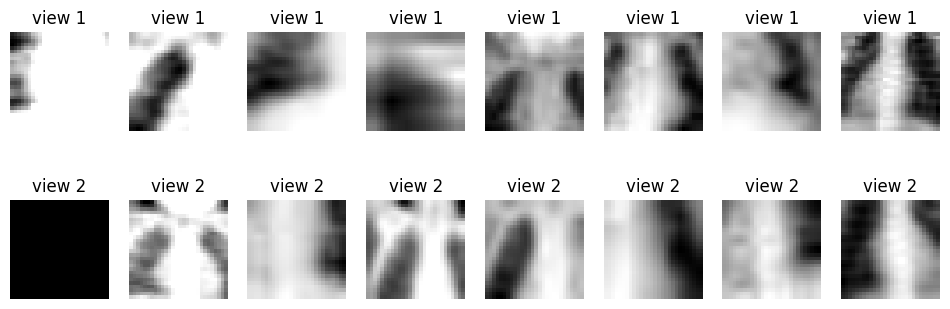

In [8]:
# DO NOT MODIFY THIS CELL! IT IS FOR CHECKING THE IMPLEMENTATION ONLY.

# Initialise data module
datamodule = SimCLRPneumoniaMNISTDataModule()
# Get train dataloader
train_dataloader = datamodule.train_dataloader()
# Get first batch
batch = next(iter(train_dataloader))
# Visualise the images
view1, view2 = batch
f, ax = plt.subplots(2, 8, figsize=(12,4))
for i in range(8):
  ax[0,i].imshow(view1[i, 0], cmap='gray')
  ax[1,i].imshow(view2[i, 0], cmap='gray')
  ax[0,i].set_title('view 1')
  ax[1,i].set_title('view 2')
  ax[0, i].axis("off")
  ax[1, i].axis("off")

## **Part B:** Implement the SimCLR loss and training step.

In this part, we ask you to:
1. Implement the SimCLR loss function, as per the equation in the lecture notes (and the [original paper](https://arxiv.org/abs/2002.05709)).
2. Once you have implemented the loss, implement the training step function in the provided LightningModule.

### **Task B-1:** SimCLR loss function.

For the implementation of the SimCLR loss, you should follow the 'recipe' from the lecture slides. We provide a code skeleton to get you started. Fill in all the blanks.

*Hint:* In PyTorch, to compute scalar products (also called dot products) between many elements efficiently, note that for two batches of $d$-dimensional feature vectors $v1$ and $v2$ of size $[N, d]$ (with $N$ being the batch size) computing the matrix multiplication `torch.mm(v1, v2.t())` returns a matrix $S$ of size $[N, N]$ where each element $S[i, j]$ is the scalar product of $v1_i$ and $v2_j$.

In [9]:
def simclr_loss(embedding_view1, embedding_view2, tau = 1.0):
  """This function implements the SimCLR loss function as described in the original paper.
  See lecture notes for formulas.

  It takes as input the embeddings from both views and returns the loss value for that batch.

  Args:
      embedding_view1 (torch.tensor): shape [batch_size, embedding_dimension]
      embedding_view2 (torch.tensor): shape [batch_size, embedding_dimension]
      tau (float, optional): temperature parameter. Defaults to 1.0.

  Returns:
      torch.tensor: shape 1
  """

  # Step 1: normalize the embeddings with L_2 normalization over the embedding_dimension
  embedding_view1 = F.normalize(embedding_view1, dim=-1)
  embedding_view2 = F.normalize(embedding_view2, dim=-1)

  # Step 2: gather all embeddings into one big vector of size [2*N , feature_dim]
  embedding_combined = torch.cat((embedding_view1, embedding_view2), dim=0)

  # Step 3: compute all possible similarities, should be a matrix of size [2 * N, 2 * N]
  # all_similarities[i,j] will be the similarity between z_all_views[i] and z_all_views[j].
  # We don't need any further division by ||i|| * ||j|| because they are already normalized. 
  all_similarities = torch.mm(embedding_combined, embedding_combined.T)

  # Step 4: Here we want to return a mask of size[2 * N, 2 * N] for which mask[i,j] = 1 if
  # z_all_views[i] and z_all_views[j] form a positive pair.
  # There should be exactly 2 * N non-zeros elements in this matrix.
  mask_self = torch.eye(all_similarities.size(0))
  mask_positive_pair = torch.roll(mask_self, shifts=embedding_view1.size(0), dims=1)

  # Step 5: self-mask. For computing the denominator term in the loss function,
  # we need to sum over all possible similarities except the self-similarity.
  # Create a mask of shape [2*N, 2*N] that is 1 for all valid pairs and 0 for all self-pairs (i = j).
  mask_negative = 1 - mask_self
  
  # Step 6: Computing all numerators for the loss function.
  # Should be vector of size [2 * N],
  # where element is exp(sim(i, j) / t) for each positive pair (i, j).
  # Re-use the computed quantities above.

  """
  print(mask_positive_pair.get_device()) # -1
  print(all_similarities.get_device())   # 0
  """

  mask_positive_pair = mask_positive_pair.to(embedding_view1.device)
  numerator = torch.exp(torch.sum(mask_positive_pair * all_similarities, dim=1)/tau)

  # Step 7: Computing all denominators for the loss function.
  # Should be a vector of size [2 * N].
  # Where each element should be the sum of exp(sim(i,k)/tau) for all k != i.

  """
  print(mask_negative.get_device())    # -1
  print(all_similarities.get_device()) # 0
  """

  mask_negative = mask_negative.to(embedding_view1.device)
  denominator = torch.sum(mask_negative * torch.exp(all_similarities/tau), dim=1)

  # Step 8: Return the final loss values, using the previously computing numerators and denominators.
  batch_loss = - torch.log(numerator / denominator)

  return torch.mean(batch_loss)

#### **Check** SimCLR loss function.

To check your implementation, please run the following tests. Note that we will also use other tests on different inputs to test your code.

In [10]:
# DO NOT MODIFY THIS CELL! IT IS FOR CHECKING THE IMPLEMENTATION ONLY.

seed_everything(33)

expected_results = [torch.tensor(1.7518), torch.tensor(1.6376), torch.tensor(4.194),  torch.tensor(4.1754)]
for i, (N, feature_dim) in enumerate(zip([3, 3, 33, 33], [5, 125, 5, 125])):
  embedding_view1 = torch.rand((N, feature_dim))#.to(device)
  embedding_view2 = torch.rand((N, feature_dim))#.to(device)
  loss = simclr_loss(embedding_view1.clone(), embedding_view2.clone(), tau=0.5)
  print(f"Expected loss: {expected_results[i]}, Computed loss: {loss}")
  assert torch.isclose(loss, expected_results[i], rtol=1e-3)
print("Passed all tests successfully !")

Seed set to 33
Seed set to 33


Expected loss: 1.7517999410629272, Computed loss: 1.7518142461776733
Expected loss: 1.6375999450683594, Computed loss: 1.637643814086914
Expected loss: 4.193999767303467, Computed loss: 4.194351673126221
Expected loss: 4.1753997802734375, Computed loss: 4.175372123718262
Passed all tests successfully !


### **Task B-2:** SimCLR training step.

In this next task you are asked to complete the blanks in the provided [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html).

We provide the implementation of an image encoder (the CNN backbone that will act as feature extractor). No changes are needed for this part.

In [11]:
class ImageEncoder(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.net = models.resnet50(weights=None)
        del self.net.fc
        self.net.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.net.conv1(x)
        x = self.net.bn1(x)
        x = self.net.relu(x)
        x0 = self.net.maxpool(x)
        x1 = self.net.layer1(x0)
        x2 = self.net.layer2(x1)
        x3 = self.net.layer3(x2)
        x4 = self.net.layer4(x3)
        x4 = self.net.avgpool(x4)
        x4 = torch.flatten(x4, 1)
        return x4

Next, you will need to complete the implementation of the SimCLR model. In order to make the training step work correctly, you will need to implement the `process_batch` function.

In [12]:
class SimCLRModel(LightningModule):
    def __init__(self, learning_rate: float = 0.001):
        super().__init__()
        self.learning_rate = learning_rate

        self.encoder = ImageEncoder()

        self.projector = torch.nn.Sequential(
            torch.nn.Linear(2048, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 128),
        )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def process_batch(self, batch):
        # Process the 'left' and 'right' execution graph separately

        x1 = self.encoder(batch[0].float())
        x1 = self.projector(x1)

        x2 = self.encoder(batch[1].float())
        x2 = self.projector(x2)

        x1 = x1.float()
        x2 = x2.float()

        loss = simclr_loss(x1, x2)

        return loss

    def training_step(self, batch, batch_idx):
        loss = self.process_batch(batch)
        self.log('train_loss', loss, prog_bar=True)
        if batch_idx == 0:
            grid = torchvision.utils.make_grid(torch.cat((batch[0][0:4, ...], batch[1][0:4, ...]), dim=0), nrow=4, normalize=True)
            self.logger.experiment.add_image('train_images', grid, self.global_step)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.process_batch(batch)
        self.log('val_loss', loss, prog_bar=True)

#### **Check** SimCLR training step.

Here you can test that your code runs fine by training the model for 5 epochs using the cell below.

Report the training and validation loss at the end of 5 epochs.

In [ ]:
# DO NOT MODIFY THIS CELL! IT IS FOR CHECKING THE IMPLEMENTATION ONLY.

seed_everything(33, workers=True)

data = SimCLRPneumoniaMNISTDataModule(batch_size=32)

model = SimCLRModel()

trainer = Trainer(
    max_epochs=5,
    accelerator='auto',
    devices=1,
    logger=TensorBoardLogger(save_dir='./lightning_logs/coursework/', name='simclr'),
    callbacks=[ModelCheckpoint(monitor='val_loss', mode='min'), TQDMProgressBar(refresh_rate=10)],
)
trainer.fit(model=model, datamodule=data)

Seed set to 33


Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type         | Params
-------------------------------------------
0 | encoder   | ImageEncoder | 23.5 M
1 | projector | Sequential   | 2.2 M 
-------------------------------------------
25.7 M    Trainable params
0         Non-trainable params
25.7 M    Total params
102.925   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/avzh1/Documents/imperial/year4/lectures/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


/home/avzh1/Documents/imperial/year4/lectures/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 148/148 [00:10<00:00, 14.60it/s, v_num=22, train_loss=1.920, val_loss=4.110]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 148/148 [00:10<00:00, 14.60it/s, v_num=22, train_loss=1.920, val_loss=4.110]


## **Part C:** Linear probing and model finetuning.

Implementation of transfer learning strategies (linear probing and finetuning) for model evaluation.

In this part, you are given two different image encoders that were pre-trained with different datasets and training strategies. The objective for this task is to assess the performance of these two encoders in a downstream classification task. For this task, you are asked to implement evaluation routines seen in the lecture: linear probing and model finetuning. The downstream task is the prediction of Pneumonia in the (small) chest X-ray images from the PneumoniaMNIST dataset.

This part can be broken down into the following tasks:
1. Adapt your PneunomiaMNIST dataset for the image classification task.
2. Implement a classification model with a linear layer attached to a pre-trained image encoder.
3. For both pre-trained encoders:
    - a) Train the classifier on top of the frozen encoder (linear probing)
    - b) Finetune the entire model (including the encoder).
4. Evaluate all models on the test set, and provide a brief summary (no more than 300 words) with an analysis of your findings.

### **Task C-1:** Adapt your PneunomiaMNIST dataset for the image classification task.

We can base our implementation largely on the `SimCLRPneumoniaMNISTDataset` and adapt it to make it suitable for image classification. Think about a suitable data augmentation pipeline. Check previous tutorials for inspiration.

In [13]:
class PneumoniaMNISTDataset(MedMNIST):
    def __init__(self, split = 'train', augmentation: bool = False):
        ''' Dataset class for Pneumonia MNST.
        The provided init function will automatically download the necessary
        files at the first class initialistion.

        :param split: 'train', 'val' or 'test', select subset

        '''
        self.flag = "pneumoniamnist"
        self.size = 28
        self.size_flag = ""
        self.root = './data/coursework/'
        self.info = INFO[self.flag]
        self.download()

        npz_file = np.load(os.path.join(self.root, "pneumoniamnist.npz"))

        self.split = split

        # Load all the images
        assert self.split in ['train','val','test']

        self.imgs = npz_file[f'{self.split}_images']
        self.labels = npz_file[f'{self.split}_labels']

        self.do_augment = augmentation

        # define the augmentation pipeline for classification
        self.augmentation_pipeline = v2.Compose([
            v2.CenterCrop((26,26)),
            # v2.Pad((0,0,2,2))
        ])

        self.default_augmentation = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True)
        ])

    def __len__(self):
        return self.imgs.shape[0]

    def __getitem__(self, index):
        # TASK: Implement the __getitem__ function to return the image and its class label.
        
        # Get the image at the indexed position
        x = np.expand_dims(self.imgs[index], axis=0)
        x = torch.from_numpy(x)

        if self.do_augment:
            x = self.augmentation_pipeline(x)

        return self.default_augmentation(x), self.labels[index]

Again, we use a [LightningDataModule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) for handling your PneumoniaMNIST dataset. No changes needed for this part.

In [14]:
class PneumoniaMNISTDataModule(LightningDataModule):
    def __init__(self, batch_size: int = 32):
        super().__init__()
        self.batch_size = batch_size
        self.train_set = PneumoniaMNISTDataset(split='train', augmentation=True)
        self.val_set = PneumoniaMNISTDataset(split='val', augmentation=False)
        self.test_set = PneumoniaMNISTDataset(split='test', augmentation=False)

    def train_dataloader(self):
        return DataLoader(dataset=self.train_set, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_set, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(dataset=self.test_set, batch_size=self.batch_size, shuffle=False)

#### **Check** dataset implementation.

Run the below cell to visualise a batch of your training dataloader.

Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz


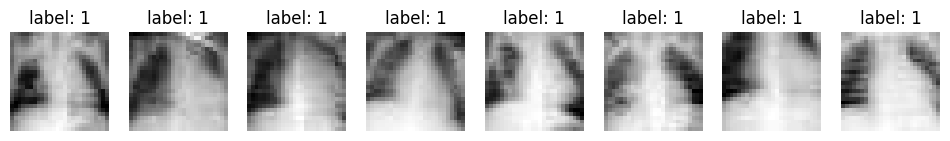

In [15]:
# DO NOT MODIFY THIS CELL! IT IS FOR CHECKING THE IMPLEMENTATION ONLY.

# Initialise data module
datamodule = PneumoniaMNISTDataModule()
# Get train dataloader
train_dataloader = datamodule.train_dataloader()
# Get first batch
batch = next(iter(train_dataloader))
# Visualise the images
images, labels = batch
f, ax = plt.subplots(1, 8, figsize=(12,4))
for i in range(8):
  ax[i].imshow(images[i, 0], cmap='gray')
  ax[i].set_title('label: ' + str(labels[i].item()))
  ax[i].axis("off")

### **Task C-2:** Implement a classification model with a linear layer attached to a pre-trained image encoder.

We first download the weights of the two pre-trained image encoders. One of them has been trained with the self-supervised SimCLR objective on a large publicly available chest X-ray dataset (different from PneunomiaMNIST). The other encoder is a standard ImageNet backbone that has been trained with a supervised classification objective on the ImageNet dataset.

In [16]:
# ! wget https://www.doc.ic.ac.uk/~bglocker/teaching/mli/coursework.zip
# ! unzip coursework.zip

We provide the function for loading the encoders. No changes needed here.

In [17]:
def load_encoder_from_checkpoint(checkpoint_path):
  ckpt = torch.load(checkpoint_path, map_location='cpu')
  simclr_module = SimCLRModel()
  print(simclr_module.load_state_dict(state_dict=ckpt))
  return simclr_module.encoder.eval()

imagenet_model = './data/coursework/model_imagenet.ckpt'
chestxray_model = './data/coursework/model_chestxray.ckpt'

Now, implement a classification model as a LightningModule for image classification using a pre-trained image encoder.

The model should have a flag in the init function `freeze_encoder` that if set to true freezes all the weights in the encoder (used for linear probing), and if set to false all weights are trainable (used for model finetuning).

*Hint:* Check out previous tutorials for inspiration on how to implement a classification model as LightningModule. For the coursework, we recommend using the Area Under the Receiver Operating Characteristic Curve (ROC-AUC) performance metric (instead of accuracy). ROC-AUC is measure of the overall discriminative power of a classification model. You can use the readily available implementation in [torchmetrics](https://lightning.ai/docs/torchmetrics/stable/classification/auroc.html#functional-interface). You should log the ROC-AUC similar to how we logged accuracy in previous tutorials.

In [34]:
# TASK: Implement the ImageClassifier class
# Check previous tutorials for inspiration on how to implement an `ImageClassifier`

class ImageClassifier(LightningModule):
    def __init__(self, 
                 pretrained_encoder: torch.nn.Module, 
                 freeze_encoder: bool = True, 
                 output_dim: int = 2, 
                 learning_rate: float = 0.001):
        super().__init__()

        self.pretrained_encoder = pretrained_encoder
        self.freeze_encoder = freeze_encoder
        self.output_dim = output_dim
        self.learning_rate = learning_rate

        # pre-trained image encoder
        for param in self.pretrained_encoder.parameters():
            param.requires_grad = not self.freeze_encoder

        # classification linear layer
        # in the paper, they implemented an MLP with one hidden layer z_i = g(h_i) = W_2*σ(W_1*h_i) where σ is a ReLU non-linearity
        self.lin_layer = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, output_dim)
        )

    def forward(self, x):
        x = self.pretrained_encoder(x)
        x = self.lin_layer(x)
        return x
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def process_batch(self, batch):
        x, y = batch
        y = y.squeeze(dim=1)

        logits = self(x)
        loss = F.cross_entropy(logits, y)

        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1).float()
        auroc_metric = auroc(preds, y, task='binary')

        return loss, auroc_metric

    def validation_step(self, batch, batch_idx):
        loss, acc = self.process_batch(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, acc = self.process_batch(batch)
        self.log('test_loss', loss)
        self.log('test_acc', acc)

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        loss, auroc_metric = self.process_batch(batch)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', auroc_metric, prog_bar=True)
        # if batch_idx == 0:
        #     grid = torchvision.utils.make_grid(batch[0][0:16, ...], nrow=4, normalize=True)
        #     self.logger.experiment.add_image('train_images', grid, self.global_step)
        return loss


### **Task C-3a:** Implement training and testing for linear probing.

Train two classification models using **linear probing**, one for each of the two provided image encoders. Evaluate on both the validation and test sets.

*Note:* Training for 25 epochs should be sufficient.

In [42]:
seed_everything(33, workers=True)

data = PneumoniaMNISTDataModule(batch_size=32)

# TASK: Implement the linear probing training and testing routines.

classifier_imageNet_linprob = ImageClassifier(pretrained_encoder = load_encoder_from_checkpoint(imagenet_model), freeze_encoder=True)
classifier_chestxray_linprob = ImageClassifier(pretrained_encoder= load_encoder_from_checkpoint(chestxray_model), freeze_encoder=True)

Seed set to 33
Seed set to 33


Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
<All keys matched successfully>


GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs


<All keys matched successfully>


In [43]:
trainer = Trainer(
    max_epochs=25,
    accelerator='auto',
    devices=1,
    logger=TensorBoardLogger(save_dir='./lightning_logs/classification/', name='classifier_imageNet_linprob'),
    callbacks=[ModelCheckpoint(monitor='val_loss', mode='min'), TQDMProgressBar(refresh_rate=10)],
)

trainer.fit(model=classifier_imageNet_linprob, datamodule=data)

print("Validation performance for ImageNet")
trainer.validate(model=classifier_imageNet_linprob, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

print("Test performance for ImageNet")
trainer.test(model=classifier_imageNet_linprob, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs/classification/classifier_imageNet_linprob
Missing logger folder: ./lightning_logs/classification/classifier_imageNet_linprob
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type         | Params
----------------------------------------------------
0 | pretrained_encoder | ImageEncoder | 23.5 M
1 | lin_layer          | Sequential   | 2.1 M 
----------------------------------------------------
2.1 M     Trainable params
23.5 M    Non-trainable params
25.6 M    Total params
102.408   Total estimated model params size (MB)

  | Name               | Type         | Params
--------------------

Epoch 24: 100%|██████████| 148/148 [00:02<00:00, 61.19it/s, v_num=0, train_loss=0.368, train_acc=1.000, val_loss=0.347, val_acc=0.896] 

`Trainer.fit` stopped: `max_epochs=25` reached.
`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 148/148 [00:02<00:00, 61.11it/s, v_num=0, train_loss=0.368, train_acc=1.000, val_loss=0.347, val_acc=0.896]

Restoring states from the checkpoint path at ./lightning_logs/classification/classifier_imageNet_linprob/version_0/checkpoints/epoch=18-step=2812.ckpt
Restoring states from the checkpoint path at ./lightning_logs/classification/classifier_imageNet_linprob/version_0/checkpoints/epoch=18-step=2812.ckpt



Validation performance for ImageNet


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./lightning_logs/classification/classifier_imageNet_linprob/version_0/checkpoints/epoch=18-step=2812.ckpt
Loaded model weights from the checkpoint at ./lightning_logs/classification/classifier_imageNet_linprob/version_0/checkpoints/epoch=18-step=2812.ckpt


Validation DataLoader 0: 100%|██████████| 17/17 [00:00<00:00, 72.18it/s]

Restoring states from the checkpoint path at ./lightning_logs/classification/classifier_imageNet_linprob/version_0/checkpoints/epoch=18-step=2812.ckpt
Restoring states from the checkpoint path at ./lightning_logs/classification/classifier_imageNet_linprob/version_0/checkpoints/epoch=18-step=2812.ckpt



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc             0.883340060710907
        val_loss            0.20424185693264008
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Test performance for ImageNet


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./lightning_logs/classification/classifier_imageNet_linprob/version_0/checkpoints/epoch=18-step=2812.ckpt
Loaded model weights from the checkpoint at ./lightning_logs/classification/classifier_imageNet_linprob/version_0/checkpoints/epoch=18-step=2812.ckpt


Testing DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 72.85it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.785427451133728
        test_loss           0.41231027245521545
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.41231027245521545, 'test_acc': 0.785427451133728}]

In [44]:
trainer = Trainer(
    max_epochs=25,
    accelerator='auto',
    devices=1,
    logger=TensorBoardLogger(save_dir='./lightning_logs/classification/', name='classifier_chestxray_linprob'),
    callbacks=[ModelCheckpoint(monitor='val_loss', mode='min'), TQDMProgressBar(refresh_rate=10)],
)

trainer.fit(model=classifier_chestxray_linprob, datamodule=data)

print("Validation performance for ChestXRay")
trainer.validate(model=classifier_chestxray_linprob, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

print("Test performance for ChestXRay")
trainer.test(model=classifier_chestxray_linprob, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs/classification/classifier_chestxray_linprob
Missing logger folder: ./lightning_logs/classification/classifier_chestxray_linprob
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name               | Type         | Params
----------------------------------------------------
0 | pretrained_encoder | ImageEncoder | 23.5 M
1 | lin_layer          | Sequential   | 2.1 M 
----------------------------------------------------
2.1 M     Trainable params
23.5 M    Non-trainable params
25.6 M    Total params
102.408   Total estimated model params size (MB)

  | Name               | Type         | Params
----------------------------------------------------
0 | pretrained_encoder | ImageEncoder | 23.5 M
1 | lin_layer          | Sequential   | 2.1 M 
----------------------------------------------------
2.1 M     Trainable params
23.5 M    Non-trainable params
25.6 M    Total params
102.408   Total estimated model params size (MB)


Epoch 3: 100%|██████████| 148/148 [00:02<00:00, 63.32it/s, v_num=0, train_loss=0.272, train_acc=0.000, val_loss=0.291, val_acc=0.861] 

/home/avzh1/Documents/imperial/year4/lectures/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 24: 100%|██████████| 148/148 [00:02<00:00, 68.55it/s, v_num=0, train_loss=0.0674, train_acc=1.000, val_loss=0.345, val_acc=0.865] 

`Trainer.fit` stopped: `max_epochs=25` reached.
`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 148/148 [00:02<00:00, 68.49it/s, v_num=0, train_loss=0.0674, train_acc=1.000, val_loss=0.345, val_acc=0.865]


Restoring states from the checkpoint path at ./lightning_logs/classification/classifier_chestxray_linprob/version_0/checkpoints/epoch=17-step=2664.ckpt
Restoring states from the checkpoint path at ./lightning_logs/classification/classifier_chestxray_linprob/version_0/checkpoints/epoch=17-step=2664.ckpt


Validation performance for ChestXRay


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./lightning_logs/classification/classifier_chestxray_linprob/version_0/checkpoints/epoch=17-step=2664.ckpt
Loaded model weights from the checkpoint at ./lightning_logs/classification/classifier_chestxray_linprob/version_0/checkpoints/epoch=17-step=2664.ckpt


Validation DataLoader 0: 100%|██████████| 17/17 [00:00<00:00, 91.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.8496582508087158
        val_loss            0.26481953263282776
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Restoring states from the checkpoint path at ./lightning_logs/classification/classifier_chestxray_linprob/version_0/checkpoints/epoch=17-step=2664.ckpt
Restoring states from the checkpoint path at ./lightning_logs/classification/classifier_chestxray_linprob/version_0/checkpoints/epoch=17-step=2664.ckpt


Test performance for ChestXRay


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./lightning_logs/classification/classifier_chestxray_linprob/version_0/checkpoints/epoch=17-step=2664.ckpt
Loaded model weights from the checkpoint at ./lightning_logs/classification/classifier_chestxray_linprob/version_0/checkpoints/epoch=17-step=2664.ckpt


Testing DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 71.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7455279231071472
        test_loss           0.5827047228813171
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5827047228813171, 'test_acc': 0.7455279231071472}]

### **Task C-3b:** Implement training and testing for model finetuning.

Repeat the experiments, but this time using model finetuning instead of linear probing. Evaluate on both the validation and test sets.

In [45]:
seed_everything(33, workers=True)

data = PneumoniaMNISTDataModule(batch_size=32)

classifier_imageNet_finetuned = ImageClassifier(pretrained_encoder = load_encoder_from_checkpoint(imagenet_model), freeze_encoder=False)
classifier_chestxray_finetuned = ImageClassifier(pretrained_encoder= load_encoder_from_checkpoint(chestxray_model), freeze_encoder=False)

Seed set to 33
Seed set to 33


Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
<All keys matched successfully>
<All keys matched successfully>


In [ ]:
trainer = Trainer(
    max_epochs=25,
    accelerator='auto',
    devices=1,
    logger=TensorBoardLogger(save_dir='./lightning_logs/classification/', name='classifier_imageNet_finetuned'),
    callbacks=[ModelCheckpoint(monitor='val_loss', mode='min'), TQDMProgressBar(refresh_rate=10)],
)

trainer.fit(model=classifier_imageNet_finetuned, datamodule=data)

print("Validation performance for ImageNet")
trainer.validate(model=classifier_imageNet_finetuned, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

print("Test performance for ImageNet")
trainer.test(model=classifier_imageNet_finetuned, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

### **Task C-4:** Your evaluation report.

Provide a brief summary (no more than 300 words) with an analysis of your findings. Try explaining the observed performance.

*Placeholder text with 300 words:*

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Sed id enim ut nibh pretium egestas. Maecenas at felis vel justo viverra ornare. Ut elit erat, sagittis in augue vel, ultrices pulvinar orci. Mauris posuere consequat lorem, non sodales purus convallis sed. Fusce ut purus eu risus pellentesque imperdiet quis a felis. Ut neque mi, porta vulputate metus in, ultrices consectetur mi. Ut eu fringilla turpis, vel accumsan felis.

Morbi maximus, nunc quis accumsan euismod, sem urna eleifend lorem, non consequat mauris diam eget elit. Praesent at massa ante. Nulla semper, turpis eget elementum iaculis, felis ex ultricies mauris, ac lobortis odio dui ut massa. Morbi luctus varius turpis, sed maximus erat ullamcorper nec. Etiam quis magna in neque commodo pretium ac nec lacus. Etiam ornare euismod pharetra. Etiam pellentesque est at lectus iaculis, et semper tellus cursus. Integer blandit tellus lacus, ac cursus nisi aliquam quis. Donec ut aliquam erat. Duis at quam at velit malesuada sagittis. Aliquam vestibulum tellus vitae nibh finibus ullamcorper. Lorem ipsum dolor sit amet, consectetur adipiscing elit. In pretium eros et est auctor ultricies. Curabitur lectus velit, vulputate blandit turpis eget, maximus interdum nunc.

Sed tincidunt scelerisque magna ut congue. Nulla porttitor a ante ac pellentesque. Nam porttitor velit vehicula, euismod ligula vitae, sagittis tortor. Mauris ut cursus augue. Morbi nec rhoncus sem. Fusce id dolor in elit faucibus laoreet. Quisque tempus odio non nisl elementum volutpat. Donec facilisis, urna sit amet congue pretium, metus ex vulputate magna, ut vulputate quam erat eu est. Aliquam diam magna, volutpat porta orci posuere, varius ornare odio. Nullam interdum faucibus sodales. Maecenas hendrerit sollicitudin erat, ut vestibulum neque interdum ac. Sed molestie suscipit rutrum. Aenean vitae ante purus. Sed sed maximus nibh. Nulla facilisi. Sed sit amet turpis vitae libero sagittis molestie a in ante. Sed ultricies interdum.

## Logging

In [ ]:
%load_ext tensorboard
%tensorboard --logdir './lightning_logs/coursework/'